<a href="https://colab.research.google.com/github/TEB-1/2020-ectf-insecure-example/blob/master/sndpid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Control System with Python
## Systems Analysis, ECE, UConn
### © Adria Kajenski and Abhishek Dutta


---



#*Second Order, Stability & PID Control*

In [0]:
# Install control library
!pip install control

     |████████████████████████████████| 256kB 2.8MB/s 
  Created wheel for control: filename=control-0.8.3-py2.py3-none-any.whl size=260982 sha256=4b5ba61caaa32606feac253d72d1348b6fc531c3d087f15eb9863cecacaf6fa2
  Stored in directory: /root/.cache/pip/wheels/c2/d9/cc/90b28cb139a6320a3af2285428b6da87eee8d8920c78bb0223
Successfully built control


_____Eigenvalue______ Damping___ Frequency_
        -2        +1j     0.8944      2.236
        -2        -1j     0.8944      2.236
[2.23606798 2.23606798]
[0.89442719 0.89442719]
[-2.+1.j -2.-1.j]
{'RiseTime': 1.2857857857857855, 'SettlingTime': 2.098598598598598, 'SettlingMin': 0.1804298201891198, 'SettlingMax': 0.2003734875183782, 'Overshoot': 0.037319639152598914, 'Undershoot': 0.0, 'Peak': 0.2003734875183782, 'PeakTime': 3.1426426426426417, 'SteadyStateValue': 0.2002987367525949}


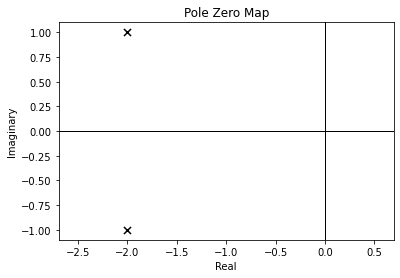

In [0]:
import control.matlab as cml
import control
import numpy as np

# A) Poles and Zeros
# Start by defining a system's poles and zeros
# Let's assume there are no zeros, so create an empty array
zeros = np.array([])
poles = np.array([-2+1j, -2-1j], dtype=complex)

# Use Matlab control function "zero, poles, gain" to create transfer function 

(num,den) = cml.zpk2tf([],poles, 1)

# The zpk2tf() function gives it in a (num,den) format, so define a  
# transfer function that you can work with

H = control.tf(num,den)
#print(H)

# Take a look at the poles and zeros map to visualize what the system looks like
(p,z) = control.pzmap(H)
(omega_n, zeta, tfpoles) = cml.damp(H)

info = control.step_info(H)

print(omega_n)
print(zeta)
print(tfpoles)
print(info)

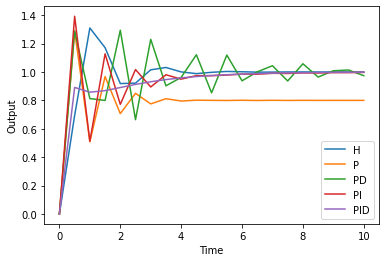

In [0]:
# B) PID Control
import matplotlib.pyplot as plt

#Define time window 
t0 = 0
t1 = 10
dt = 0.5

t = np.arange(t0, t1+dt, dt)

#Define input signal - step function 
u0 = np.ones(5) #Could use zeros here if you wanted to start the signal later 
u1 = np.ones(len(t)-len(u0))

u = np.concatenate((u0, u1), axis = 0)

#Define initial state
X0 = 0

#Define transfer function
num = [0, 0, 9]
den = [1, 2, 9]

H = control.tf(num,den)

H_cl = control.feedback(H, 1)

#Response of system with no controller 
(timeH, yH, xH) = control.forced_response(H, t, u, X0)

# Look at controller terms
Kp = 4
KI = 2
KD = 2

# Proportional Controller: Kp term only
numP = [Kp]
denP = [1]
P = control.tf(numP, denP)
H_p = control.feedback(control.series(H, P),1)
(timeP, yP, xP) = control.forced_response(H_p, t, u, X0)

# PD Controller: want transfer function sKD + Kp
numPD = [KD, Kp]
denPD = [1, 0]
PD = control.tf(numPD,denPD)
H_PD = control.feedback(control.series(H, PD), 1)
(timePD, yPD, xPD) = control.forced_response(H_PD, t, u, X0)

# PI Controller: want transfer function (Kp + KI/s) = (sKp + KI)/s
numPI = [Kp, KI]
denPI = [1,0]
PI = control.tf(numPI,denPI)
H_PI = control.feedback(control.series(H,PI),1)
(timePI, yPI, xPI) = control.forced_response(H_PI, t, u, X0)

# PID controller: want transfer function of form (Kp + KI/s + sKD)
numPID = [KD, Kp, KI]
denPID = [1,0]
PID = control.tf(numPID, denPID)
H_PID = control.feedback(control.series(H, PID), 1)
(timePID, yPID, xPID) = control.forced_response(H_PID, t, u, X0)


plt.plot(timeH, yH) 
plt.plot(timeP, yP)
plt.plot(timePD, yPD)
plt.plot(timePI, yPI)
plt.plot(timePID,yPID)

plt.xlabel('Time'); plt.ylabel('Output')
plt.legend(labels=('H', 'P', 'PD', 'PI', 'PID'))

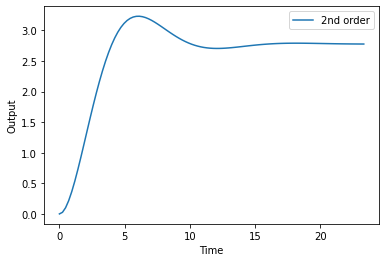

In [0]:
# C) Using Given Time Specs and Sympy
import sympy as sp

zeta = 0.5

# Derivations available in lecture notes
# t_r ~= 1.8/omega_n
# t_s = 3/sigma
# t_p = pi/omega_d
#M_p = e^(-(pi*zeta)/sqrt(1 - zeta^2))

omega_n, omega_d, sigma = sp.symbols('omega_n, omega_d, sigma')

# Let's say we're given t_r < 3
# ** t_r = 1.8/omega_n < 3
t_r = 3

# Given that t_p < 4
# ** t_p = pi/omega_d
t_p = 2

# Given that t_s < 5
# ** t_s = 3/sigma
t_s = 5

# Use sympy to solve for natural frequency
omega_n_solved = sp.solveset(sp.Eq(1.8/omega_n, t_r))
# sp.solveset returns as a Finite Value, so need to convert it to a list
omega_nlist = list(omega_n_solved)
# Once it's in a list we can extract the value
v_omega_n = np.asarray(omega_nlist, dtype=float)

# Use sympy to solve for damped frequency
omega_d_solved = sp.solveset(sp.Eq(np.pi/omega_d, t_p))
# Convert Finite Value to a list like before, and extract value
omega_dlist = list(omega_d_solved)
v_omega_d = np.asarray(omega_dlist, dtype = float)

# Use sympy to solve for settling time
sigma_solved = sp.solveset(sp.Eq(3/sigma, t_s))
# Convert Finite Value to a list like before, and extract value
sigma_list = list(sigma_solved)
v_sigma = np.asarray(sigma_list, dtype = float)


# Can solve for overshoot Mp
Mp = np.exp(-1*np.pi*zeta/(np.sqrt(1 - zeta**2)))

# Second order System
num = [1]
den = [1, 2*zeta*v_omega_n[0], v_omega_n[0]**2]

tf2 = control.tf(num,den)
#print(tf)
T, yout = control.step_response(tf2)
plt.plot(T,yout,label="2nd order")
plt.xlabel('Time'); plt.ylabel('Output')
plt.legend(); plt.show()

In [0]:
# D) Solving for K, again utilizing sympy 
from sympy import *

# Define initial transfer function 
s, Kp, KI, KD = symbols('s, Kp, KI, KD')

# Plant transfer function 
Gp = (4)/(s**2 + 2*s + 4)

Gc = Kp #KI/s, sKD, or any combination

# Simplify our transfer function
H = simplify((Gc*Gp)/(1+Gc*Gp))

# Extract just denominator from transfer function
den = expand(denom(H))

# Extract coefficients from denominator

a0 = den.coeff(s, 2)
a1 = den.coeff(s, 1)
a2 = den.coeff(s, 0)

print('Denominator:', den)
print('s^2:', a0)
print('s^1:', a1)
print('s^0:', a2)

# Using the standard second order equation, we can compare the coefficients
# We can take our time specifications like we did in the previous file, 
# and then use solveset to find the K values i.e.:
Kp_solv = solveset(Eq(a2, 6), Kp)

Denominator: 4*Kp + s**2 + 2*s + 4
s^2: 1
s^1: 2
s^0: 4*Kp + 4
